In [2]:
!pip install --user -U imbalanced-learn
# Опять импорт либ
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

Requirement already up-to-date: imbalanced-learn in c:\users\student\appdata\roaming\python\python38\site-packages (0.8.0)


In [3]:
# Импорт датасетов
df = pd.read_csv('data/encoded_playlist_songs.csv')
df_fav = pd.read_csv('data/favorite_songs.csv')

### Подготовка данных для модели

In [4]:
# Убираем название, автора, альбом
df = pd.concat([df, df_fav], axis=0)
df.shape

(8933, 13)

In [5]:
df.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,7MAibcTli4IisCtbHKrGMh,242096,90,0.586,0.1820,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
1,5QO79kh1waicV47BqGRL3g,215626,97,0.680,0.0212,0.826,0.000012,0.5430,-5.487,0.0309,118.051,4,0
2,1diS6nkxMQc3wwC4G1j0bh,165506,88,0.722,0.0319,0.588,0.000000,0.1830,-5.932,0.0544,134.010,4,0
3,4u4NyuceXP7Uzh7XFJKCr1,170813,89,0.658,0.0106,0.634,0.000000,0.1320,-5.797,0.0413,139.980,4,0
4,3Ofmpyhv5UAQ70mENzB277,132780,94,0.778,0.1750,0.695,0.000000,0.1500,-6.865,0.0913,149.996,4,0


In [6]:
df['favorite'].value_counts()

0    8883
1      50
Name: favorite, dtype: int64

# Выбор моделей и подбор параметров

In [19]:
# Опять импорт склёрна
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score
# 3 модельки которые тестил, позже напишу какую выбрал
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

## Разделяем датасет на тестовый и тренировочный

In [7]:
# Перемешиваем
shuffle_df = df.sample(frac=1)

# Обьявлем размер тестового (80% как обычно) 
train_size = int(0.8 * len(df))

# Разделяем на тестовый и тренировочный
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

In [8]:
train_set.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
8410,6Y44dF7imG5uM719odQr7a,498280,31,0.233,0.99300,0.153,0.844000,0.0607,-14.080,0.0462,77.006,4,0
6965,2FDBZsJdZf1xeUsdMlH76j,210266,47,0.418,0.81900,0.133,0.149000,0.2830,-20.707,0.0376,108.331,4,0
1626,305WCRhhS10XUcH6AEwZk6,213800,75,0.613,0.00148,0.953,0.000582,0.1520,-3.435,0.0855,105.046,4,0
6298,5YN0zHycJ0Yxz31A5QsVov,188656,61,0.687,0.05360,0.707,0.000093,0.1600,-6.190,0.0328,127.033,4,0
2585,5NnFkbEjahUGx5T3qxbNCW,265558,64,0.529,0.10600,0.755,0.000607,0.1570,-3.917,0.0383,73.998,4,0


In [9]:
# Разделяем на x_test и y_test
X = train_set.drop(columns=['favorite', 'track_id'])
y = train_set.favorite

X.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
8410,498280,31,0.233,0.99300,0.153,0.844000,0.0607,-14.080,0.0462,77.006,4
6965,210266,47,0.418,0.81900,0.133,0.149000,0.2830,-20.707,0.0376,108.331,4
1626,213800,75,0.613,0.00148,0.953,0.000582,0.1520,-3.435,0.0855,105.046,4
6298,188656,61,0.687,0.05360,0.707,0.000093,0.1600,-6.190,0.0328,127.033,4
2585,265558,64,0.529,0.10600,0.755,0.000607,0.1570,-3.917,0.0383,73.998,4


In [10]:
# Сравниваем на дисбаланс
y.value_counts()

0    7109
1      37
Name: favorite, dtype: int64

Так как любимых песен ничтожно мало по сравнению с всем датасетом - мы берём средние значения любимых песен и заполняем ими остатки. Оверсэмплинг короче.

In [11]:
# Train / Split Data
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X, y) 

In [12]:
X_train.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,498280,31,0.233,0.99300,0.153,0.844000,0.0607,-14.080,0.0462,77.006,4
1,210266,47,0.418,0.81900,0.133,0.149000,0.2830,-20.707,0.0376,108.331,4
2,213800,75,0.613,0.00148,0.953,0.000582,0.1520,-3.435,0.0855,105.046,4
3,188656,61,0.687,0.05360,0.707,0.000093,0.1600,-6.190,0.0328,127.033,4
4,265558,64,0.529,0.10600,0.755,0.000607,0.1570,-3.917,0.0383,73.998,4


In [13]:
# Вот теперь нет такого дисбаланса
y_train.value_counts()

1    7109
0    7109
Name: favorite, dtype: int64

Теперь когда количество любимых песен и всего датасета равно, мы можем не беспокоится о кривизне обучения

In [14]:
test_set.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
2565,6eUuwMYJv8p68UGT5u4FZS,263786,43,0.285,0.0283,0.417,0.276000,0.236,-14.126,0.0480,97.437,3,0
2658,11MSSonvzz9Fu8RTdTXnqd,187401,46,0.553,0.6350,0.449,0.000000,0.255,-5.857,0.0322,77.633,4,0
1334,4PDfwhqOmkkocOHg4Rh4Mq,220650,53,0.579,0.0379,0.646,0.000499,0.114,-4.638,0.0402,87.962,4,0
548,3UmaczJpikHgJFyBTAJVoz,404106,79,0.780,0.0371,0.768,0.000002,0.518,-4.325,0.2380,80.063,4,0
967,7aXXjA800sXYKpM8D9pCVT,278800,45,0.693,0.0901,0.880,0.000000,0.211,-3.228,0.0661,88.088,4,0


In [15]:
# Обьявляем тестовые датасеты
X_test = test_set.drop(columns=['favorite', 'track_id'])
y_test = test_set['favorite']

In [16]:
X_test.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
2565,263786,43,0.285,0.0283,0.417,0.276000,0.236,-14.126,0.0480,97.437,3
2658,187401,46,0.553,0.6350,0.449,0.000000,0.255,-5.857,0.0322,77.633,4
1334,220650,53,0.579,0.0379,0.646,0.000499,0.114,-4.638,0.0402,87.962,4
548,404106,79,0.780,0.0371,0.768,0.000002,0.518,-4.325,0.2380,80.063,4
967,278800,45,0.693,0.0901,0.880,0.000000,0.211,-3.228,0.0661,88.088,4


In [17]:
# Вот на тестовом так и должно быть
y_test.value_counts()

0    1774
1      13
Name: favorite, dtype: int64

## Проверка моделей

Классическая логистическая регрессия будет стандартом для сравнения с ней других моделей. Я решил использовать ещё две: Дерево решений и Случайный лес. Возможно их показатели будут лучше логистической регрессии.

In [20]:
%%time
# Логичтисческая регрессия
lr = LogisticRegression(solver='lbfgs', max_iter=400).fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.8033009889922026
Wall time: 392 ms


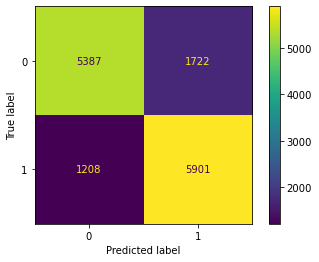

In [21]:
# Логистическая регрессия на матрице ошибок
lr_preds = lr.predict(X_train)
plot_confusion_matrix(lr, X_train, y_train)

In [22]:
# Оптимизация гиперпараметров для дерева решений(взял из инета)
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [23]:
%%time
# Дерево решений
dt = DecisionTreeClassifier(max_depth=30).fit(X_train, y_train)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

Wall time: 1.34 s


0.992920802401153

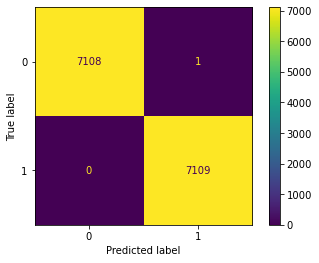

In [24]:
# Дерево решений на матрице ошибок (Офигеть результаты)
plot_confusion_matrix(dt, X_train, y_train)

In [25]:
%%time
# Оптимизация гиперпараметров для случайного леса, ес чесно понятия не имею что это такое, но для обучения двух этих моделек надо это
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

Wall time: 18.5 s


{'max_depth': 20, 'n_estimators': 20}

In [26]:
%%time
# Случайный лес
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 10, max_depth = 20).fit(X_train, y_train))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

Wall time: 2.07 s


0.9965626740929139

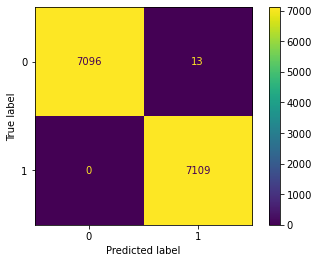

In [27]:
plot_confusion_matrix(rf, X_train, y_train)

Хотя и у случайного леса точность больше - я буду использовать дерево решений т.к. у него меньше ошибок на матрице


### Тестируем алгоритм на тестовой дате

In [28]:
# ИМБАЛАНС
y_test.value_counts()

0    1774
1      13
Name: favorite, dtype: int64

In [29]:
#скопипастил

# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=30))
pipe.fit(X_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(max_depth=30))])

pipe.score(X_test, y_test)

0.9860100727476218

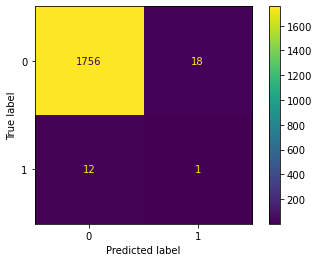

In [30]:
plot_confusion_matrix(dt, X_test, y_test)

Вообщем есть ложно позитивные результаты - но это хорошо в целом будет больше песен в плэйлисте

## Предсказываем песни и создаём плэйлист

In [31]:
# Перезагружаем датасет
df = pd.read_csv('data/encoded_playlist_songs.csv')

In [32]:
df.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,7MAibcTli4IisCtbHKrGMh,242096,90,0.586,0.1820,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
1,5QO79kh1waicV47BqGRL3g,215626,97,0.680,0.0212,0.826,0.000012,0.5430,-5.487,0.0309,118.051,4,0
2,1diS6nkxMQc3wwC4G1j0bh,165506,88,0.722,0.0319,0.588,0.000000,0.1830,-5.932,0.0544,134.010,4,0
3,4u4NyuceXP7Uzh7XFJKCr1,170813,89,0.658,0.0106,0.634,0.000000,0.1320,-5.797,0.0413,139.980,4,0
4,3Ofmpyhv5UAQ70mENzB277,132780,94,0.778,0.1750,0.695,0.000000,0.1500,-6.865,0.0913,149.996,4,0


In [33]:

prob_preds = pipe.predict_proba(df.drop(['favorite','track_id'], axis=1))
threshold = 0.30
preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
df['prediction'] = preds

In [34]:
df['prediction'].value_counts()

0    8867
1      16
Name: prediction, dtype: int64

## Создаем плэйлист по рекоммендованым песням

In [35]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [36]:
# Данные со споти
cid = '02d33d68c8724a3fb5209f420a3e4d1a'
secret = '7e1ecf62485a4fec84700590a1453e9f'
redirect_uri='http://localhost:7777/callback'
username = '9xg1dh4sogilprh9kw0cdw3wi'

In [37]:
# Создаем ключ
scope = 'user-top-read playlist-modify-private playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [38]:
# Создаём функцию которая создаст плэйлист на аккаунте
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [39]:
create_playlist(sp, username, 'Это предсказано нейросетью', 'Спасибо API Spotify')

In [40]:
# Проверяем нормально ли создался плэйлист
def fetch_playlists(sp, username):
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [44]:
fetch_playlists(sp,username).head()

,id,name,#tracks
0,1gDkeRorQapKF3NQ8LRHwO,Это предсказано нейросетью,0
1,37i9dQZF1EIYNLJQIbCGRL,GLXY Mix,50
2,37i9dQZF1EIWu7dsXC9UwJ,LAKEY INSPIRED Mix,50
3,37i9dQZF1EIW0s45NHWRsz,Emperor Mix,50
4,37i9dQZF1DWYBO1MoTDhZI,Good Vibes,138


In [45]:
# Сохраняем id плэйлиста для того чтобы позже добавлять в него новые предсказанные трэки
playlist_id = fetch_playlists(sp,username)['id'][0]

In [46]:
# Функция для добавления предсказанных треков в плэйлист
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [47]:
# Добавляем песни в плэйлист
list_track = df.loc[df['prediction']  == 1]['track_id']
enrich_playlist(sp, username, playlist_id, list_track)

Теперь в меня на акке создался плэйлистю. Результаты вполне неплохие.